# Exit Tickets
* Via Not Not Todd, "What other evaluation techniques are there? How does AUC compare? When to apply them?"

In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the data.
path = '/Users/dimitrilinde/Documents/GA-DS-PT/24/decision-trees/data/titanic.csv'
titanic = pd.read_csv(path)

# Encode female as 0 and male as 1.
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# Fill in the missing values for age with the median age.
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# Create a DataFrame of dummy variables for Embarked.
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame.
titanic = pd.concat([titanic, embarked_dummies], axis=1)

feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic[feature_cols]
y = titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2]:
# probability of surviving for first 5 passengers in test split
rfc.predict_proba(X_test)[:5,1]

array([1.        , 0.06166667, 0.949     , 0.24894156, 0.08865886])

In [4]:
# store probabilities
preds = rfc.predict_proba(X_test)[:,1]
# use a list comprehension to set all values at or above .5 to 1 and below to 0 and create confusion matrix
conmat = confusion_matrix(y_test, [1 if x>=.5 else 0 for x in preds])
# format it so it looks nice
confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                         columns=['Pred: 0','Pred: 1'])
confusion

,Pred: 0,Pred: 1
Actual: 0,97,14
Actual: 1,21,47


In [30]:
print(conmat)
# get the false positives
fp = conmat[0][1]
# the true positives
tp = conmat[1][1]
# the false negatives
fn = conmat[1][0]
# and the true negatives
tn = conmat[0][0]
# and divide the false positives by all the predicted positives to get the false positive rate when the threshold
# equals .5
fpr = fp/(fp+tn)
fpr

[[111   0]
 [ 57  11]]


0.0

In [31]:
# if we want to see fpr at multiple thresholds, we need to store our results
result_list = []
#preds = rfc.predict_proba(X_test)[:,1]
for i in range(0,101):
    # multiplying i by .01 yields every value between 0 and 1.0 in increments of .01
    i = i*.01
    # create our confusion matrix at each threshold
    conmat = confusion_matrix(y_test, [1 if x>=i else 0 for x in preds])
    # derive fpr at threshold
    fp = conmat[0][1]
    tp = conmat[1][1]
    fn = conmat[1][0]
    tn = conmat[0][0]
    fpr = fp/(fp+tn)
    tpr = tp/(fn+tp)
    # put threshold and fpr in a list
    result = [i,fpr,tpr]
    # append to result list
    result_list.append(result)
result_list[:5]

[[0.0, 1.0, 1.0],
 [0.01, 0.7927927927927928, 0.9411764705882353],
 [0.02, 0.7117117117117117, 0.9264705882352942],
 [0.03, 0.6666666666666666, 0.9117647058823529],
 [0.04, 0.6486486486486487, 0.9117647058823529]]

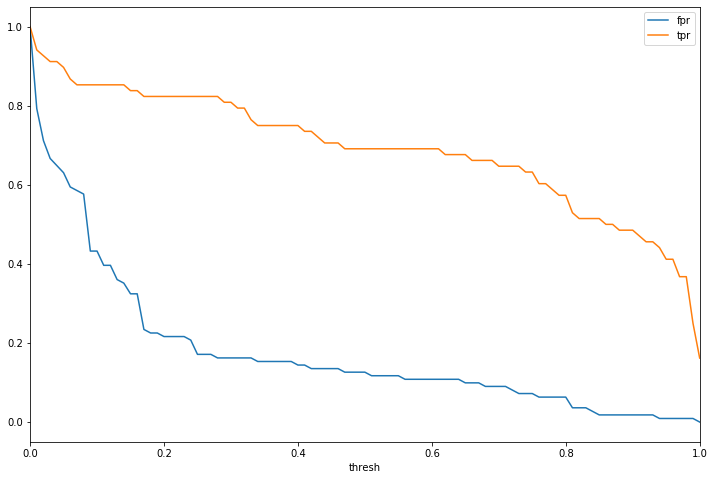

In [32]:
# store result in dataframe
pr_by_thresh = pd.DataFrame(result_list,columns=['thresh','fpr','tpr'])
# plot result
fig, ax = plt.subplots(nrows=1, ncols=1) 
pr_by_thresh.plot(x='thresh',y='fpr',ax=ax,figsize=(12,8))
pr_by_thresh.plot(x='thresh',y='tpr',ax=ax,figsize=(12,8))
plt.show()

In [33]:
# at a threshold of zero, we predict everything is positve, so we get 100% false positives, and 100% true positves
# at .1, we are getting 85% of positves, but we're predicting 43% of negatives are positives
pr_by_thresh[pr_by_thresh.thresh.isin([0,.1,.5,.9,1])]

,thresh,fpr,tpr
0,0.0,1.000000,1.000000
10,0.1,0.432432,0.852941
50,0.5,0.126126,0.691176
90,0.9,0.018018,0.485294
100,1.0,0.000000,0.161765


### Imagine you have a model that predicts whether individuals are covid carriers
* What of the 4 metrics in the confusion matrix seems particularly important to increase/reduce?
* What are the consequences of increasing/reducing those metrics (the impacts on the remaining metrics)?

### Metrics/models spreadsheet
https://docs.google.com/spreadsheets/d/1tvcwYQxwQ_1nRvWJbfg2er6zknaTP_XuG_lteOlxdIg/edit?usp=sharing